# Introduction
The Diabetes prediction dataset is a collection of medical and demographic data from patients, along with their diabetes status (positive or negative). The data includes features such as age, gender, body mass index (BMI), hypertension, heart disease, smoking history, HbA1c level, and blood glucose level. This dataset can be used to build machine learning models to predict diabetes in patients based on their medical history and demographic information. This can be useful for healthcare professionals in identifying patients who may be at risk of developing diabetes and in developing personalized treatment plans. Additionally, the dataset can be used by researchers to explore the relationships between various medical and demographic factors and the likelihood of developing diabetes.

# Imports

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.svm import SVC

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import (classification_report, accuracy_score, 
                             precision_recall_fscore_support, confusion_matrix, 
                             precision_score, recall_score, roc_auc_score, f1_score)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, 
                              AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier)
from sklearn.neighbors import KNeighborsClassifier


import warnings

warnings.filterwarnings('ignore')

# Load Dataset and Data Exploration

In [23]:
file_path = "dataset\diabetes_prediction_dataset.csv"

# Load the latest version
df = pd.read_csv(file_path)

In [24]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history',
       'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes'],
      dtype='object')

In [25]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [26]:
df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


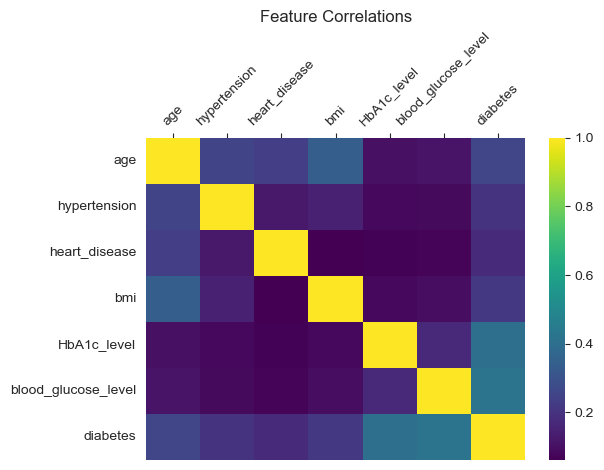

In [27]:
numerical_df = df.select_dtypes(include=['number'])  # extract only numerical datatypes

sns.heatmap(numerical_df.corr(), cmap='viridis')

plt.title("Feature Correlations")
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=45)
plt.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
plt.tight_layout()
plt.show()

## Examining the target value - Diabetes

In [28]:
prediction_goal = 'diabetes'
df[prediction_goal].value_counts()

diabetes
0    91500
1     8500
Name: count, dtype: int64

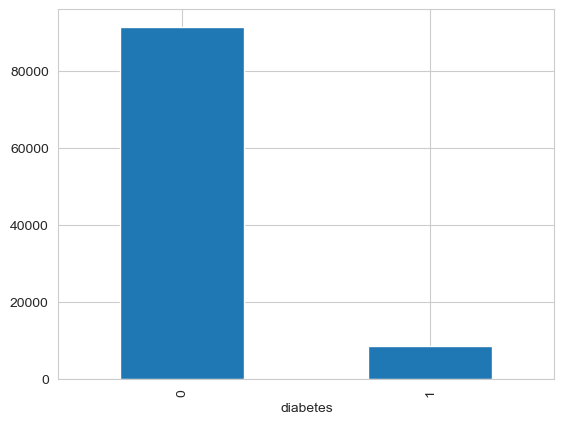

In [29]:
df[prediction_goal].value_counts().plot.bar()
plt.show()

This is an imbalanced dataset, where less than 10% of the patient have (positive) diabetes.

## Identify numerical vs categorical columns

In [30]:
df.nunique()

gender                    3
age                     102
hypertension              2
heart_disease             2
smoking_history           6
bmi                    4247
HbA1c_level              18
blood_glucose_level      18
diabetes                  2
dtype: int64

In [31]:
# Printing categorical values where number of uniues are less than 7 (smoking).
for col in df.columns:
    if df[col].nunique() < 7:
        print(f"Uniques values in column {str(col)}: {df[col].unique()}")

print()
df_without_target= df.drop(columns=[prediction_goal])
categorical_df = df_without_target.columns[df_without_target.nunique()<7]
numerical_df = df_without_target.columns[df_without_target.nunique()>=7]
print(f"List of categorical columns: {categorical_df.tolist()}")
print(f"List of numerical columns: {numerical_df.tolist()}")

Uniques values in column gender: ['Female' 'Male' 'Other']
Uniques values in column hypertension: [0 1]
Uniques values in column heart_disease: [1 0]
Uniques values in column smoking_history: ['never' 'No Info' 'current' 'former' 'ever' 'not current']
Uniques values in column diabetes: [0 1]

List of categorical columns: ['gender', 'hypertension', 'heart_disease', 'smoking_history']
List of numerical columns: ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']


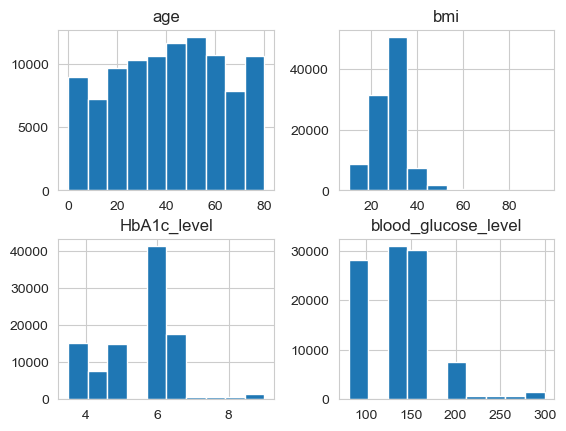

In [32]:
df[numerical_df].hist()
plt.show()

In [33]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

With above information, we can also say that our dataset have no null/missing values that need to be handled.

# Preprocessing

In [34]:
X = df.drop(prediction_goal, axis=1)  # drop the prediction/target column from the dataframe object
y = df[[prediction_goal]]  # get the prediction/target column as dataframe object

In [35]:
# Initialize objects to prepare/transform our input dataset for predictionto error in case of doubt
encoder = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore")
# drop first columns per category to avoid redundancy. [Male: [0,1], Female:[0,1]} --> {Male:[0,1]}
# sparse false to keep readability, but should be considered for memory efficient processing
# handle_unknown set to ignore, as we don't expect out of box input to be prediction in our scenario, can be set 
scaler = StandardScaler()
label_encoder = LabelEncoder()

# Initialize column transformer/normalizer
column_transformer = ColumnTransformer( transformers=[('one_hot_encoded', encoder, categorical_df.tolist()),
                                                      ('scaler', scaler, numerical_df.tolist())], remainder="passthrough")
# remainder="passthrough", will leave any columns that doesn't fall in any category as it is.

# transform input
column_transformer.fit(X)  # learn the encoding/scaling
X = column_transformer.transform(X)  # apply the encoding/scaling

# transform output
label_encoder.fit(y.values.ravel())  # learn the label encoder
y[prediction_goal] = label_encoder.fit_transform(y[prediction_goal])  # apply the label encoder

## Prepare training dataset

In [36]:
# Split the data into training and validation sets
random_state= 33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = random_state)

## Feature Engineering (handling imbalanced dataset)

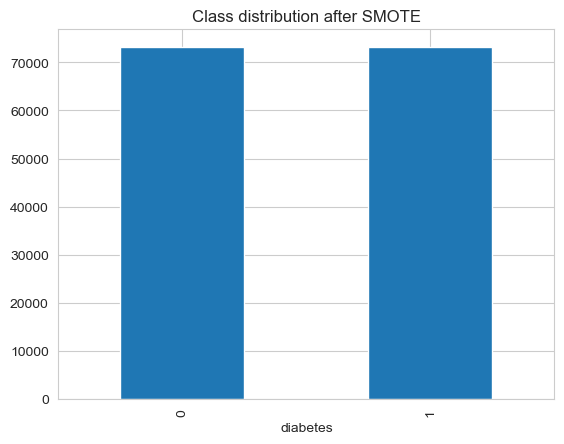

In [37]:
# We will handle the imbalanced dataset with Synthetic Minority Oversampling Technique (SMOTE)
smote_sampler = SMOTE(random_state = random_state)
X_smote, y_smote = smote_sampler.fit_resample(X_train, y_train)
y_smote[prediction_goal].value_counts().plot.bar()
plt.title("Class distribution after SMOTE")
plt.show()

In [38]:
# Setting up Evaluation Methods
def evaluate(yt, yp, eval_type="Original"):
    results_pos = {}
    results_pos['type'] = eval_type
    results_pos['accuracy'] = accuracy_score(yt, yp)
    results_pos['recall'] = recall_score(yt, yp)
    results_pos['auc'] = roc_auc_score(yt, yp)
    results_pos['precision'] = precision_score(yt, yp)
    results_pos['fscore'] = f1_score(yt, yp)
    return results_pos

    

# Models Testing

In [39]:
models = {
    "Logistic Regression": LogisticRegression(random_state=random_state),
    "Decision Tree": DecisionTreeClassifier(random_state=random_state),
    "RandomForest": RandomForestClassifier(random_state=random_state, class_weight={0: 0.1, 1: 0.9}),
}

evaluations = {}
for name, model in models.items():
    # Original dataset
    model.fit(X_train, y_train)  # Train model
    y_pred = model.predict(X_test)  # Predict on test data
    original_dataset_eval = evaluate(y_test, y_pred)    
    # SMOTE
    model.fit(X_smote, y_smote)
    y_pred = model.predict(X_test)
    smote_dataset_eval = evaluate(y_test, y_pred, "SMOTE")
    results = [original_dataset_eval, smote_dataset_eval]
    evaluations[name] = results



       type  accuracy    recall       auc  precision    fscore
0  Original    0.9576  0.608824  0.799412   0.849754  0.709390
1     SMOTE    0.8856  0.873529  0.880125   0.417369  0.564854


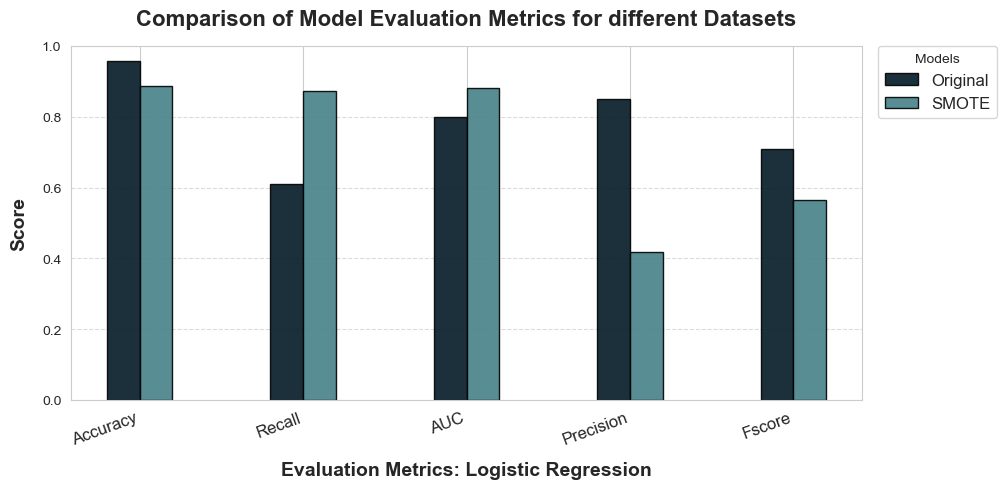

       type  accuracy    recall       auc  precision    fscore
0  Original   0.94855  0.715882  0.843023   0.690301  0.702859
1     SMOTE   0.94625  0.734118  0.850037   0.667023  0.698964


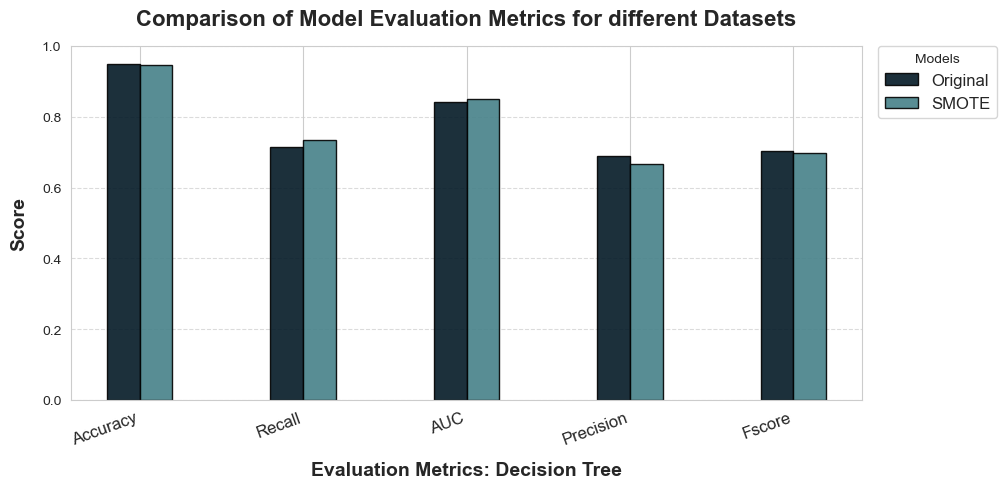

       type  accuracy    recall       auc  precision    fscore
0  Original    0.9672  0.659412  0.827602   0.935726  0.773637
1     SMOTE    0.9562  0.705882  0.842668   0.761421  0.732601


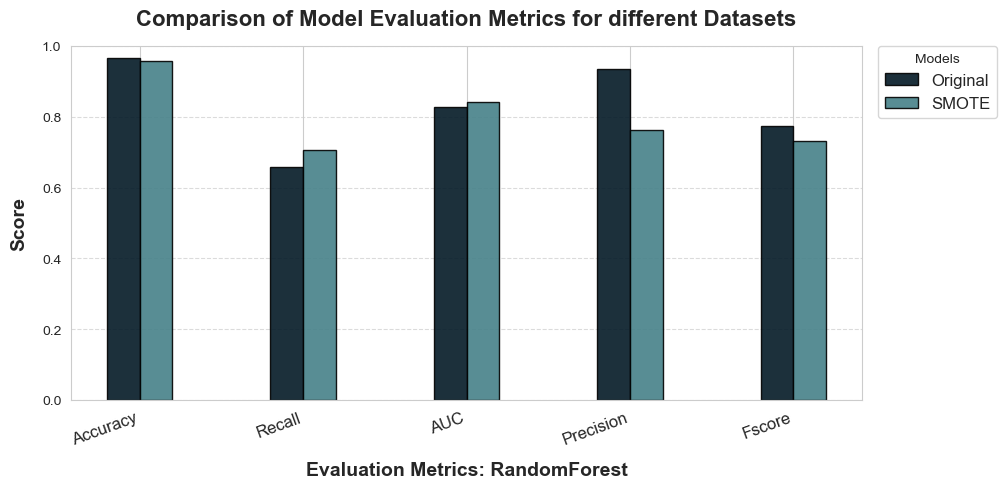

In [40]:
def visualize_eval_metrics(results, model_name):
    df = pd.DataFrame(data=results)
    print(df)
    
    metrics = ['Accuracy', 'Recall', 'AUC', 'Precision', 'Fscore']
    x = np.arange(len(metrics))
    methods = df['type'].values  # Extract method names dynamically
    num_methods = len(methods)
    
    # Adjust bar width dynamically based on the number of models
    width = min(0.8 / num_methods, 0.2)
    offsets = np.linspace(-width * (num_methods - 1) / 2, width * (num_methods - 1) / 2, num_methods)
    
    plt.figure(figsize=(12, 5), dpi=100)  # Increased height for better spacing
    
    # Define a color palette that supports up to 7 methods
    color_palette = ['#031926', '#468189', '#9DBEBB', '#f4e9cd', '#a4969b', '#655560', '#666a86']
    colors = color_palette[:num_methods]  # Select colors based on number of methods

    for i, (method, offset, color) in enumerate(zip(methods, offsets, colors)):
        plt.bar(x + offset, df.iloc[i, 1:].values, width, color=color, label=method, alpha=0.9, edgecolor='black')

    # Rotate x-axis labels for better readability
    plt.xticks(x, metrics, fontsize=12, rotation=20, ha='right')  

    plt.xlabel(f"Evaluation Metrics: {model_name}", fontsize=14, fontweight="bold", labelpad=10)
    plt.ylabel("Score", fontsize=14, fontweight="bold", labelpad=10)
    plt.title("Comparison of Model Evaluation Metrics for different Datasets", fontsize=16, fontweight="bold", pad=15)
    
    # Move the legend outside the chart (to the right)
    plt.legend(title="Models", fontsize=12, loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0)
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Light grid for readability
    plt.ylim(0, 1)  # Assuming metric scores are between 0 and 1
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make room for the legend

    plt.show()    



for name, evals in evaluations.items():
    visualize_eval_metrics(evals, name)

In [41]:
evaluations

{'Logistic Regression': [{'type': 'Original',
   'accuracy': 0.9576,
   'recall': 0.6088235294117647,
   'auc': np.float64(0.7994117647058824),
   'precision': 0.8497536945812808,
   'fscore': 0.7093899931459904},
  {'type': 'SMOTE',
   'accuracy': 0.8856,
   'recall': 0.8735294117647059,
   'auc': np.float64(0.8801253616200577),
   'precision': 0.4173693086003373,
   'fscore': 0.5648535564853556}],
 'Decision Tree': [{'type': 'Original',
   'accuracy': 0.94855,
   'recall': 0.7158823529411765,
   'auc': np.float64(0.8430231436837029),
   'precision': 0.690300623936472,
   'fscore': 0.702858792954086},
  {'type': 'SMOTE',
   'accuracy': 0.94625,
   'recall': 0.7341176470588235,
   'auc': np.float64(0.8500369656059146),
   'precision': 0.6670229823623731,
   'fscore': 0.6989638756650798}],
 'RandomForest': [{'type': 'Original',
   'accuracy': 0.9672,
   'recall': 0.6594117647058824,
   'auc': np.float64(0.8276020572163292),
   'precision': 0.9357262103505843,
   'fscore': 0.773636991028

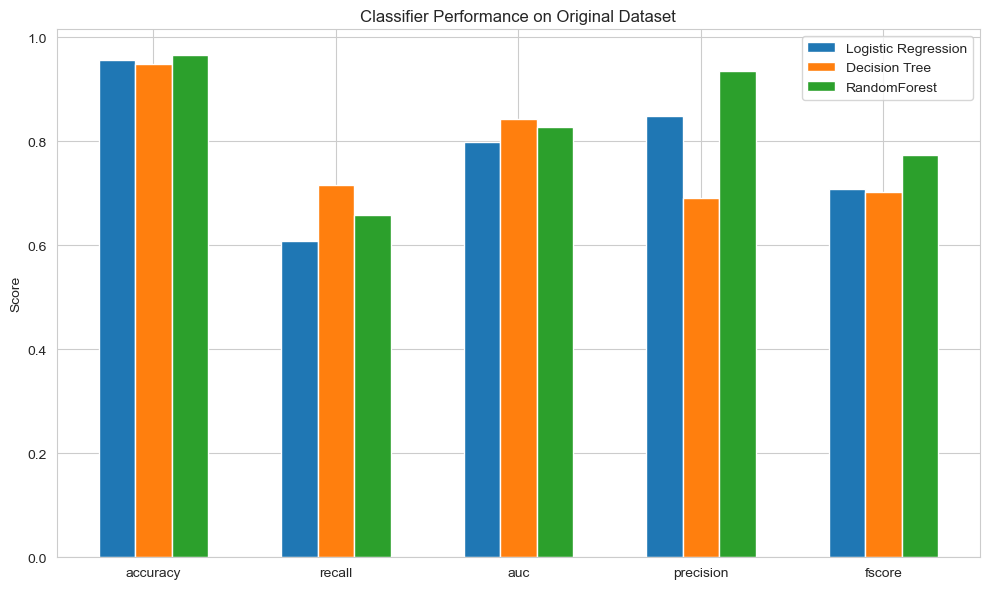

In [42]:
# Metrics to plot
metrics = ['accuracy', 'recall', 'auc', 'precision', 'fscore']
classifiers = list(evaluations.keys())

# Gather values for plotting
values = []
for clf in classifiers:
    values.append([evaluations[clf][0][metric] for metric in metrics])

x = np.arange(len(metrics))
bar_width = 0.2

# Plotting
plt.figure(figsize=(10, 6))
for i, (clf, vals) in enumerate(zip(classifiers, values)):
    plt.bar(x + i * bar_width, vals, width=bar_width, label=clf)

plt.xticks(x + bar_width, metrics)
plt.ylabel("Score")
plt.title("Classifier Performance on Original Dataset")
plt.legend()
plt.tight_layout()
plt.show()

# Model Selection
Best Overall Model: RandomForest

Highest Accuracy (0.9672)

Highest Precision (0.9357)

With very good AUC (0.8276), Recall (0.6594) and F1-score (0.7736)


# Why every metric is important:
If you're dealing with imbalanced classification, you should not rely on:

Accuracy (it can be misleading, especially in case of imbalanced dataset)

Plain F1-score (unless it’s macro or weighted)

Instead, go with:

✅ Recall or Precision-Recall AUC if catching the minority class is crucial

✅ Macro F1-score to evaluate both classes equally

✅ AUC-PR over ROC-AUC if the imbalance is severe

RandomForest model provides the best balance across all metrics.

On the other hand, decision trees is slightly better compared to logistic regression. Decision trees also has best AUC score among all.  

# Further model research
It is possible to test other models like AdaBoost and Gradient boost, but due to their complexity, the gains in accuracy comes at the cost of model interpretability. 